$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [95]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hidden Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf, http://calinon.ch/papers/Calinon-HFR2016.pdf


## Learning Hidden Markov Model (HMM)

In [96]:
from scipy.io import loadmat # loading data from matlab

letter = 'C' # choose a letter in the alphabet

datapath = os.path.dirname(pbd.__file__) + '/data/2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)

demos_x = [d['pos'][0][0].T for d in data['demos'][0]] # Position data
demos_dx = [d['vel'][0][0].T for d in data['demos'][0]] # Velocity data
demos_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(demos_x, demos_dx)] # Position-velocity

EM did not converge


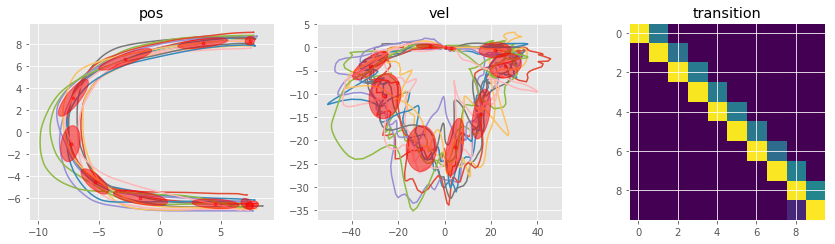

In [212]:
model = pbd.HMM(nb_states=10, nb_dim=4)

model.init_hmm_kbins(demos_xdx) # initializing model

# EM to train model
model.em(demos_xdx, reg=1e-3) 


# plotting
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,3.5)

# position plotting
ax[0].set_title('pos')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 

# velocity plotting
ax[1].set_title('vel')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 


# plotting transition matrix
ax[2].set_title('transition')
ax[2].imshow(np.log(model.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

# Reproduction (LQR) 
Using Product of Gaussian formulation with augmented transfer matrices see : http://calinon.ch/papers/Calinon-HFR2016.pdf


### Get sequence of states 

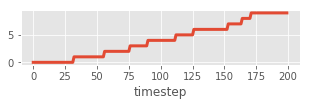

In [213]:
demo_idx = 0
sq = model.viterbi(demos_xdx[demo_idx])

plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3);
plt.xlabel('timestep');

### Regularize velocity
Allow the model to have more variations in the velocity to go to the via-point.

In [214]:
regularize_velocity = True

if regularize_velocity:
    std_vel = 20.
    model.sigma[:, 2:, 2:] += std_vel ** 2 * np.eye(2)

model.lmbda = np.linalg.inv(model.sigma)# reset lmbda

## Create and solve LQR 

In [215]:
A, b = pbd.utils.get_canonical(2, 2, 0.01)

In [216]:
lqr = pbd.LQR(A, b, horizon=demos_xdx[demo_idx].shape[0])
lqr.gmm_xi = model, sq
lqr.gmm_u = -5.

In [217]:
lqr.ricatti()

In [218]:
# create a two state GMM to define target distribution for via point
# state 0: when via-point does not apply, zero-centered and zero-precision
# state 1: when via-point apply with a precision only for position variables
via_point = [-2.5, -2.]
model_vp = pbd.GMM(nb_dim=2, nb_states=2)
# specifiy the means
model_vp.mu = np.array([
        [0., 0., 0., 0.], # state 0, position and velocity
        via_point + [0., 0.]# state 1, position and velocity
    ])

# specify the precision matrices
std_vp_pos = 0.1
model_vp.lmbda = np.zeros((2, 4, 4))
model_vp.lmbda[1, :2, :2] = 0.1 ** -2 * np.eye(2)

In [219]:
start_vp = 100  # starting time of via point cost
dur_vp = 10  # duration of the via point cost

lqr_vp = pbd.LQR(A, b, horizon=lqr.horizon)

# create sequence of state [0, 0, 0, ... , 1, 1, 1, ... 0, 0, ....]
seq_vp = [0] * (lqr_vp.horizon-start_vp) + [1] * dur_vp + [0] * (lqr_vp.horizon - start_vp - dur_vp)
# feed model and sequence
lqr_vp.gmm_xi = model_vp, seq_vp
lqr_vp.gmm_u = -5.

In [220]:
lqr_vp.ricatti()

In [221]:
def get_product_policy(x, t):
    # get Gaussian policies of LQR
    u, lmbda_u = -lqr.K[t].dot(x) + lqr.cs[t], lqr.Q[t]
    u_vp, lmbda_u_vp = -lqr_vp.K[t].dot(x) + lqr_vp.cs[t], lqr_vp.Q[t]
    
    # compute product of Gaussian policies
    lmbda_u_vp = lmbda_u + lmbda_u_vp
    sigma_u_vp = np.linalg.inv(lmbda_u_vp)
    u_p = sigma_u_vp.dot(lmbda_u.dot(u) + lmbda_u_vp.dot(u_vp))
    
    return u_p, sigma_u_vp, lmbda_u_vp

In [222]:
def integrate_policy(xi0, stochastic=False, wo_vp=False): 
    xis = [np.copy(xi0)]

    for i in range(0, lqr.horizon-1):
        if wo_vp:
            u, lmbda_u = -lqr.K[i].dot(xis[-1]) + lqr.cs[i], lqr.Q[i]
            sigma_u = np.linalg.inv(lmbda_u)
        else:
            u, sigma_u, lmbda_u = get_product_policy(xis[-1], i)  
        
        if stochastic:
            u = np.random.multivariate_normal(u, sigma_u)
        
        xis += [A.dot(xis[-1]) + b.dot(u)]
    
    return np.array(xis)

In [227]:
xi = integrate_policy(demos_xdx[demo_idx][0], stochastic=False)
xi_wo_vp = integrate_policy(demos_xdx[demo_idx][0], stochastic=False, wo_vp=True)

## Plotting reproduced trajectory (position and velocity)

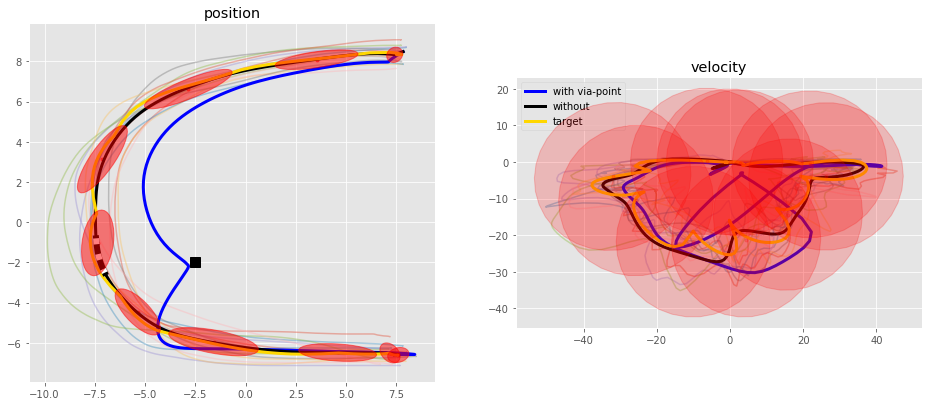

In [228]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16,8)


# position plotting 
ax[0].set_title('position')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 
    
ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
ax[0].plot(xi_wo_vp[:, 0], xi_wo_vp[:, 1], 'k', lw=3)
ax[0].plot(lqr.ds[:, 0], lqr.ds[:, 1], 'gold', lw=3)
ax[0].plot(
    xi_wo_vp[start_vp:start_vp+dur_vp, 0], 
    xi_wo_vp[start_vp:start_vp+dur_vp, 1], 'k', lw=6)
ax[0].plot(
    xi_wo_vp[start_vp:start_vp+dur_vp, 0], 
    xi_wo_vp[start_vp:start_vp+dur_vp, 1], 'w:', lw=6)

ax[0].plot(via_point[0], via_point[1], 'ks', ms=10)
# velocity plotting
ax[1].set_title('velocity')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1], alpha=0.4)
    
ax[1].plot(xi[:, 2], xi[:, 3], 'b', lw=3, label='with via-point')
ax[1].plot(xi_wo_vp[:, 2], xi_wo_vp[:, 3], 'k', lw=3, label='without')
ax[1].plot(lqr.ds[:, 2], lqr.ds[:, 3], 'gold', lw=3, label='target')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.legend()
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3], alpha=0.2); 


### Stochastic sampling 

In [229]:
xis = []

for i in range(20):
    xi = integrate_policy(demos_xdx[demo_idx][0], stochastic=False)
    xis += [xi]    

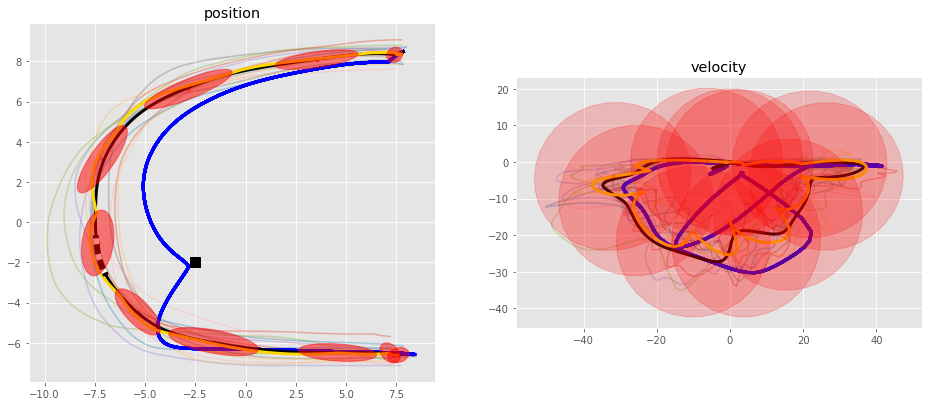

In [232]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16,8)


# position plotting 
ax[0].set_title('position')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 

for xi in xis:
    ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
    
ax[0].plot(xi_wo_vp[:, 0], xi_wo_vp[:, 1], 'k', lw=3)
ax[0].plot(lqr.ds[:, 0], lqr.ds[:, 1], 'gold', lw=3)
ax[0].plot(
    xi_wo_vp[start_vp:start_vp+dur_vp, 0], 
    xi_wo_vp[start_vp:start_vp+dur_vp, 1], 'k', lw=6)
ax[0].plot(
    xi_wo_vp[start_vp:start_vp+dur_vp, 0], 
    xi_wo_vp[start_vp:start_vp+dur_vp, 1], 'w:', lw=6)

ax[0].plot(via_point[0], via_point[1], 'ks', ms=10)
# velocity plotting
ax[1].set_title('velocity')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1], alpha=0.4)
    
for xi in xis:
    ax[1].plot(xi[:, 2], xi[:, 3], 'b', lw=3, label='with via-point')
    
ax[1].plot(xi_wo_vp[:, 2], xi_wo_vp[:, 3], 'k', lw=3, label='without')
ax[1].plot(lqr.ds[:, 2], lqr.ds[:, 3], 'gold', lw=3, label='target')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# plt.legend()
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3], alpha=0.2); 
